# MFRE Data Analytics Coordinator Teaching Seminar: 

## How does the CAD/USD exchange rate affect real food prices?

October 26th, 2022

Harry Izatt

In [ ]:
# installing packages and setting path to working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

path="C:\\Users\\jonah\\Documents\\Career\\MFRE\\working_df"
os.chdir(path)

In [283]:
excaus_df = pd.read_csv("excaus_df.csv")
excaus_df.head()

,DATE,EXCAUS
0,1971-01-01,1.0118
1,1971-02-01,1.0075
2,1971-03-01,1.0064
3,1971-04-01,1.0077
4,1971-05-01,1.0087


In [284]:
excaus_df.tail()

,DATE,EXCAUS
616,2022-05-01,1.2859
617,2022-06-01,1.2804
618,2022-07-01,1.2936
619,2022-08-01,1.2917
620,2022-09-01,1.3339


In [285]:
cpi_df = pd.read_csv("18100004.csv")
cpi_df.head()

C:\Users\jonah\AppData\Local\Temp\ipykernel_31544\2619853993.py:1: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  cpi_df = pd.read_csv("18100004.csv")


,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1914-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.200,6.0,NaN,NaN,NaN,1
1,1914-01,Canada,2016A000011124,All-items (1992=100),1992=100,7,units,0,v41713403,2.309,7.2,NaN,NaN,t,1
2,1914-01,Canada,2016A000011124,Goods and services,2002=100,17,units,0,v41691221,2.273,6.0,NaN,NaN,t,1
3,1914-02,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.200,6.0,NaN,NaN,NaN,1
4,1914-02,Canada,2016A000011124,All-items (1992=100),1992=100,7,units,0,v41713403,2.309,7.2,NaN,NaN,t,1


In [ ]:
#cpi_df.iloc[:, 11].unique()
#cpi_df.iloc[:, 13].unique()

### Note: the columns `status` and `terminated` are of mixed type

The former is either NaN or "E", the latter is either NaN or "T". Neither is relevant, so they will be ignored.

# Economic Understanding

`excaus_df` is the EXCAUS dataframe from the Federal Reserve Economic Data (FRED) database hosted by the St. Louis Fed branch. It states the exchange rate of Canadian dollars per US dollar at a monthly level from 1971 onwards. The higher the EXCAUS value, the more Canadian dollars it takes to equal one US dollar. 

A higher value indicates a stronger USD relative to the Canadian dollar, while a lower value suggests the USD weakening relative to the Canadian dollar.

`cpi_df` is the Bank of Canada's general monthly Consumer Price Index covering data across national, provincial, and city-level geographies. The CPI is calculated by taking the value of a fixed basket of goods, setting a base year price, and dividing each other year's basket price by the base year price and multiplying by 100. This gives an estimate of how the overall price level has changed since the base year.

For example, take a basket of 5 apples and 5 oranges.

- in the base year, Apples are $1 and Oranges are $2 each, therefore the base year basket price is $15
- the next year, Apples are $1.1 and Oranges are $2.50, therefore the next year's basket price is $18

It is trivial to show the base year's CPI is 100: $15/$15*100 = 100.

Next year's CPI is: $18/$15*100 = 120.

CPI's increase by a factor of 1.2 suggests 20% yearly inflation.

![](https://file%2B.vscode-resource.vscode-cdn.net/c%3A/Users/jonah/Documents/Career/MFRE/working_df/CPI.png?version%3D1666736746124)

# Data Understanding and Basic Setup

Due to the varied geographies covered in `cpi_df`, I want to check what these are, and what their time coverages are.

In [289]:
cpi_df.groupby("GEO").min()

C:\Users\jonah\AppData\Local\Temp\ipykernel_31544\2139975444.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  cpi_df.groupby("GEO").min()


,REF_DATE,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,SYMBOL,DECIMALS
GEO,,,,,,,,,,,,
Alberta,1978-09,2016A000248,Alcoholic beverages,1992=100,7,units,0,v1043024081,23.1,1.8,NaN,1
British Columbia,1978-09,2016A000259,Alcoholic beverages,1992=100,7,units,0,v1043024082,26.1,0.0,NaN,1
"Calgary, Alberta",1971-01,2011S0503825,All-items,1992=100,7,units,0,v41692924,25.2,8.5,NaN,1
Canada,1914-01,2016A000011124,Air transportation,1992=100,7,units,0,v1043024071,2.1,3.1,NaN,1
"Charlottetown and Summerside, Prince Edward Island",1974-01,NaN,All-items,1992=100,7,units,0,v41692852,6.2,26.2,NaN,1
"Edmonton, Alberta",1971-01,2011S0503835,All-items,1992=100,7,units,0,v41692918,24.2,11.6,NaN,1
"Halifax, Nova Scotia",1971-01,2011S0503205,All-items,1992=100,7,units,0,v41692858,8.2,12.7,NaN,1
"Iqaluit, Nunavut",2002-12,2011A00056204003,All-items,2002=100,17,units,0,v41713432,31.2,99.8,NaN,1
Manitoba,1978-09,2016A000246,Alcoholic beverages,1992=100,7,units,0,v1043024079,18.1,11.0,NaN,1


In [290]:
#cpi_df.groupby("GEO").max()

- We have Canada overall, provinces, and specified important cities, each with its own CPI. 

- Canada overall has CPI data reaching back to 1914, 
- The provinces generally cover from 1978 onwards

The cell directly above takes the latest month covered for each geography - it's September 2022 for every unit, so I've commented it out. 

Since we're less interested in cities, and want to view Canada and provinces separately, I'm going to subset two datasets:

1. `canada_cpi` with just Canada as `GEO` value
2. `prov_cpi` with provinces' `GEO` values

In [291]:
# creating list of province names
province_list = ["Alberta", "British Columbia", "Saskatchewan", "Manitoba", "Ontario", "Quebec", 
                 "New Brunswick", "Newfoundland and Labrador", "Nova Scotia", "Prince Edward Island"]

# creating subset dataframe only where `GEO` is in the list of provinces
prov_cpi = cpi_df[cpi_df["GEO"].isin(province_list)]
canada_cpi = cpi_df[cpi_df["GEO"]=="Canada"]

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
1058770,2022-09,British Columbia,2016A000259,Goods,2002=100,17,units,0,v41692582,26.274,141.2,NaN,NaN,NaN,1
1058771,2022-09,British Columbia,2016A000259,Durable goods,2002=100,17,units,0,v41692583,26.275,104.9,NaN,NaN,NaN,1
1058772,2022-09,British Columbia,2016A000259,Semi-durable goods,2002=100,17,units,0,v41692584,26.276,109.3,NaN,NaN,NaN,1
1058773,2022-09,British Columbia,2016A000259,Non-durable goods,2002=100,17,units,0,v41692585,26.277,172.6,NaN,NaN,NaN,1
1058774,2022-09,British Columbia,2016A000259,Services,2002=100,17,units,0,v41692586,26.282,153.4,NaN,NaN,NaN,1


# Analysis topic: How does the monthly exchange rate affect CPI growth, over different food categories and provincial regions?

I will be using exchange rate as an explanatory variable, to analyze its correlation with food prices over time. In addition, I will take unit fixed effects for Western and Eastern provinces (in comparison with Central provinces), and dummy variables for different types of food. 

My outcome variable will be `real_food_cpi`, equal to the specific type's CPI divided by `All-items cpi` and multiplied by 100. 


The steps involved in doing this are:

1. Assign provincial region dummy variables (for Western and Eastern, with Central as the base case)
2. Subset out food value entries in the `Products and product groups` column
3. Attaching exchange rate and `all-items` values with a `merge` or `join` command
4. Find real_cpi by dividing the specific food type CPI by `All-items` and multiplying by 100
 - Visualizing general food real CPI, divided by region 
5. Regression models
 - Setting up OLS dataframe
 - Running regression
 - Discussing results

# Data Preparation

# 1. Assigning regional dummy variables

In [294]:
# creating variables
prov_cpi["eastern"] = 0
prov_cpi["central"] = 0
prov_cpi["western"] = 0

# setting to 1 based on region
prov_cpi.loc[prov_cpi["GEO"] == "Newfoundland and Labrador", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Prince Edward Island", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Nova Scotia", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "New Brunswick", "eastern"] = 1

prov_cpi.loc[prov_cpi["GEO"] == "Ontario", "central"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Quebec", "central"] = 1

prov_cpi.loc[prov_cpi["GEO"] == "British Columbia", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Alberta", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Manitoba", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Saskatchewan", "western"] = 1


C:\Users\jonah\AppData\Local\Temp\ipykernel_31544\2549918419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov_cpi["eastern"] = 0
C:\Users\jonah\AppData\Local\Temp\ipykernel_31544\2549918419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov_cpi["central"] = 0
C:\Users\jonah\AppData\Local\Temp\ipykernel_31544\2549918419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# 2. Subsetting to food types and `All-items`

We want:

One dataframe with `Products and product groups` values of:
- "Food"
- "Bakery and cereal products (excluding baby food)"
- "Dairy products and eggs"
- "Meat"
- "Vegetables and vegetable preparations"

Another dataframe with just "All-items" to be merged with the above, and used to calculate Real CPI.

In [296]:
foods = ["Food", "Bakery and cereal products (excluding baby food)", "Dairy products and eggs", "Meat", "Vegetables and vegetable preparations"]
food_cpi = prov_cpi[prov_cpi["Products and product groups"].isin(foods)]

all_items = prov_cpi[prov_cpi["Products and product groups"] == "All-items"]
all_items.head()

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,eastern,central,western
39784,1978-09,Newfoundland and Labrador,2016A000210,All-items,2002=100,17,units,0,v41691244,3.2,38.6,NaN,NaN,NaN,1,1,0,0
39894,1978-09,Prince Edward Island,2016A000211,All-items,2002=100,17,units,0,v41691379,5.2,39.3,NaN,NaN,NaN,1,1,0,0
40002,1978-09,Nova Scotia,2016A000212,All-items,2002=100,17,units,0,v41691513,7.2,38.2,NaN,NaN,NaN,1,1,0,0
40112,1978-09,New Brunswick,2016A000213,All-items,2002=100,17,units,0,v41691648,9.2,38.2,NaN,NaN,NaN,1,1,0,0
40222,1978-09,Quebec,2016A000224,All-items,2002=100,17,units,0,v41691783,11.2,37.6,NaN,NaN,NaN,1,0,1,0


In [ ]:
print(food_cpi["UOM"].unique())
print(all_items["UOM"].unique())

['2002=100']
['2002=100']


Quickly confirming that all are normalized to the same base year.

# 3. Merging exchange rates and `all_items` onto `foods_cpi`

This will require making columns that match every year-month entry of `foods_cpi` and `excaus_df`, and every province-year-month for `foods_cpi` and `all_items`.

First I will match to `excaus_df` to bring in exchange rate. 

In [298]:
food_cpi["REF_DATE"].head()
#type(food_cpi["REF_DATE"][0])
food_cpi["REF_DATE"]

39785      1978-09
39787      1978-09
39794      1978-09
39799      1978-09
39803      1978-09
            ...   
1058641    2022-09
1058643    2022-09
1058652    2022-09
1058658    2022-09
1058664    2022-09
Name: REF_DATE, Length: 26450, dtype: object

In [299]:
excaus_df.head()
#type(excaus_df["DATE"][0])

,DATE,EXCAUS
0,1971-01-01,1.0118
1,1971-02-01,1.0075
2,1971-03-01,1.0064
3,1971-04-01,1.0077
4,1971-05-01,1.0087


As we can see, `food_cpi` has date market just by year-month, while `excaus_df` uses the first day of every month. If I drop the day entry of `excaus_df`, I can match it with `food_cpi` on `DATE` and `REF_DATE`

In [301]:
excaus_df["REF_DATE"] = excaus_df['DATE'].astype(str).str[:7]
excaus_df.drop("DATE", axis=1, inplace=True)
excaus_df

,EXCAUS,REF_DATE
0,1.0118,1971-01
1,1.0075,1971-02
2,1.0064,1971-03
3,1.0077,1971-04
4,1.0087,1971-05
...,...,...
616,1.2859,2022-05
617,1.2804,2022-06
618,1.2936,2022-07
619,1.2917,2022-08


In [302]:
# joining `excaus_df` to `food_cpi`

food_cpi = food_cpi.merge(excaus_df, on="REF_DATE")
food_cpi.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products and product groups', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'eastern', 'central',
       'western', 'EXCAUS'],
      dtype='object')

So, now we've got exchange rate added. Next, I need to merge in the `All-items` CPI, in the dataframe `all_items`

These two are structurally the same. However, I need them to be matched by not just date, but also geography. So, in my merge command, I'll be merging on a list of columns, `["REF_DATE", "GEO"]`. Since I don't want to bring every column across, I'm going to drop most columns from the `all_items` dataframe before merging, and rename the `VALUE` columns to `all_price_value` for clarity after merging.

In [304]:
all_items_merge = all_items.copy()
all_items_merge.drop(["DGUID", 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 
                      'COORDINATE', "SYMBOL", "TERMINATED", "DECIMALS", 'eastern', 'central',
                      'western', "STATUS"], axis=1, inplace=True)
all_items_merge.rename(columns={"VALUE": "all_price_value"},inplace=True)                      
all_items_merge

,REF_DATE,GEO,Products and product groups,all_price_value
39784,1978-09,Newfoundland and Labrador,All-items,38.6
39894,1978-09,Prince Edward Island,All-items,39.3
40002,1978-09,Nova Scotia,All-items,38.2
40112,1978-09,New Brunswick,All-items,38.2
40222,1978-09,Quebec,All-items,37.6
...,...,...,...,...
1058061,2022-09,Ontario,All-items,154.1
1058211,2022-09,Manitoba,All-items,155.2
1058351,2022-09,Saskatchewan,All-items,155.7
1058496,2022-09,Alberta,All-items,160.1


In [305]:
# now merging all-items CPI onto food_cpi
all_food_cpi = food_cpi.merge(all_items_merge, on=["REF_DATE", "GEO"])
all_food_cpi.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products and product groups_x', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'eastern', 'central',
       'western', 'EXCAUS', 'Products and product groups_y',
       'all_price_value'],
      dtype='object')

# 4. Calculating `real_cpi` from `VALUE` and `all_price_value`

This involves dividing the specific food CPIs (in the `VALUE` column) by the all 

In [306]:
all_food_cpi["real_cpi"] = 100*all_food_cpi["VALUE"]/all_food_cpi["all_price_value"]
all_food_cpi.drop(['DGUID', "UOM", "UOM_ID", "SCALAR_FACTOR", "SCALAR_ID", "VECTOR", "COORDINATE", "STATUS", "SYMBOL", "TERMINATED", "DECIMALS", "Products and product groups_y"], axis= 1, inplace=True)
all_food_cpi

,REF_DATE,GEO,Products and product groups_x,VALUE,eastern,central,western,EXCAUS,all_price_value,real_cpi
0,1978-09,Newfoundland and Labrador,Food,44.1,1,0,0,1.1664,38.6,114.248705
1,1978-09,Newfoundland and Labrador,Meat,49.3,1,0,0,1.1664,38.6,127.720207
2,1978-09,Newfoundland and Labrador,Dairy products and eggs,43.1,1,0,0,1.1664,38.6,111.658031
3,1978-09,Newfoundland and Labrador,Bakery and cereal products (excluding baby food),37.9,1,0,0,1.1664,38.6,98.186528
4,1978-09,Newfoundland and Labrador,Vegetables and vegetable preparations,41.4,1,0,0,1.1664,38.6,107.253886
...,...,...,...,...,...,...,...,...,...,...
26445,2022-09,British Columbia,Food,168.4,0,0,1,1.3339,147.8,113.937754
26446,2022-09,British Columbia,Meat,191.4,0,0,1,1.3339,147.8,129.499323
26447,2022-09,British Columbia,Dairy products and eggs,160.0,0,0,1,1.3339,147.8,108.254398
26448,2022-09,British Columbia,Bakery and cereal products (excluding baby food),168.1,0,0,1,1.3339,147.8,113.734777


What we have now is a dataframe with date, geography, product type, raw product CPI, dummy variables for region, monthly exchange rate, all_price CPI, and `real_cpi` calculated from the specific food's CPI and all-price CPI.  

# Is it useful to visualize CPI trends over time?

With 5 products, 10 provincs, 3 regions, and 44 years, we're going to have to visualize a subset of the date. 

I'll be using the overall `Food` real CPI, showing the 3 regions over time. Anything more is too many lines to interpret!

In [351]:
# subsetting by food type

just_food_cpi = all_food_cpi[all_food_cpi["Products and product groups_x"] == "Food"]

# also subsetting the others
# these are unused but could be plugged in instead!
meat_cpi = all_food_cpi[all_food_cpi["Products and product groups_x"] == "Meat"]
dairy_cpi = all_food_cpi[all_food_cpi["Products and product groups_x"] == "Dairy products and eggs"]
bakery_cpi = all_food_cpi[all_food_cpi["Products and product groups_x"] == "Bakery and cereal products (excluding baby food"]
vegetable_cpi = all_food_cpi[all_food_cpi["Products and product groups_x"] == "Vegetables and vegetable preparations"]

# pivoting: indexed by date, each column is the values of food's real cpi for that time and geography 
geo_food = pd.pivot_table(data=just_food_cpi, index = "REF_DATE", columns="GEO", values="real_cpi")
geo_food

GEO,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan
REF_DATE,,,,,,,,,,
1978-09,108.602151,99.744246,109.164420,106.806283,114.248705,107.329843,109.166667,110.178117,103.457447,113.368984
1978-10,109.042553,100.253807,108.994709,106.735751,116.581633,106.976744,109.041096,108.793970,103.439153,114.893617
1978-11,107.915567,99.242424,108.707124,105.897436,115.365239,105.912596,108.672087,108.521303,103.149606,112.928760
1978-12,107.368421,99.497487,107.631579,106.153846,115.075377,106.153846,108.943089,108.728180,104.177546,113.421053
1979-01,108.376963,101.000000,108.115183,107.397959,116.290727,106.887755,110.215054,109.181141,105.440415,113.766234
...,...,...,...,...,...,...,...,...,...,...
2022-05,106.030151,112.251882,107.152146,116.579974,107.894737,112.010276,112.817176,111.860175,115.514905,110.533160
2022-06,104.894672,111.672355,106.439150,116.191710,107.618438,111.693291,112.176166,111.581569,115.063887,109.523810
2022-07,105.638166,113.008130,107.533806,117.673814,109.429121,113.018507,112.936611,113.457944,115.410498,110.421995


In [309]:
# 10 provinces is too many time trends to visualize 
# I'm averaging across regions to make `region_food` which can be visualized

region_food = geo_food.reset_index()
region_food["east"] = region_food["New Brunswick"] + region_food["Newfoundland and Labrador"] + region_food["Nova Scotia"] + region_food["Prince Edward Island"]
region_food["east"] = region_food["east"]/4

region_food["central"] = region_food["Ontario"] + region_food["Quebec"]
region_food["central"] = region_food["central"]/2

region_food["west"] = region_food["Alberta"] + region_food["British Columbia"] + region_food["Manitoba"] + region_food["Saskatchewan"] 
region_food["west"] = region_food["west"]/4

region_food.drop(["Alberta", "British Columbia", "Manitoba", "New Brunswick",
                  "Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia",
                  "Ontario", "Quebec", "Saskatchewan"], axis=1, inplace=True)

dates = region_food["REF_DATE"]
dates = pd.to_datetime(dates)

region_food
#region_food.set_index("REF_DATE")

GEO,REF_DATE,east,central,west
0,1978-09,109.640737,106.312057,107.719950
1,1978-10,109.772024,106.240125,108.296172
2,1978-11,108.924144,105.910847,107.198469
3,1978-12,109.027812,106.560318,106.979635
4,1979-01,109.939396,107.827734,107.814595
...,...,...,...,...
524,2022-05,112.086290,114.166041,108.991835
525,2022-06,111.771252,113.620026,108.132497
526,2022-07,113.394847,114.173554,109.150524
527,2022-08,114.859689,115.283289,111.176336


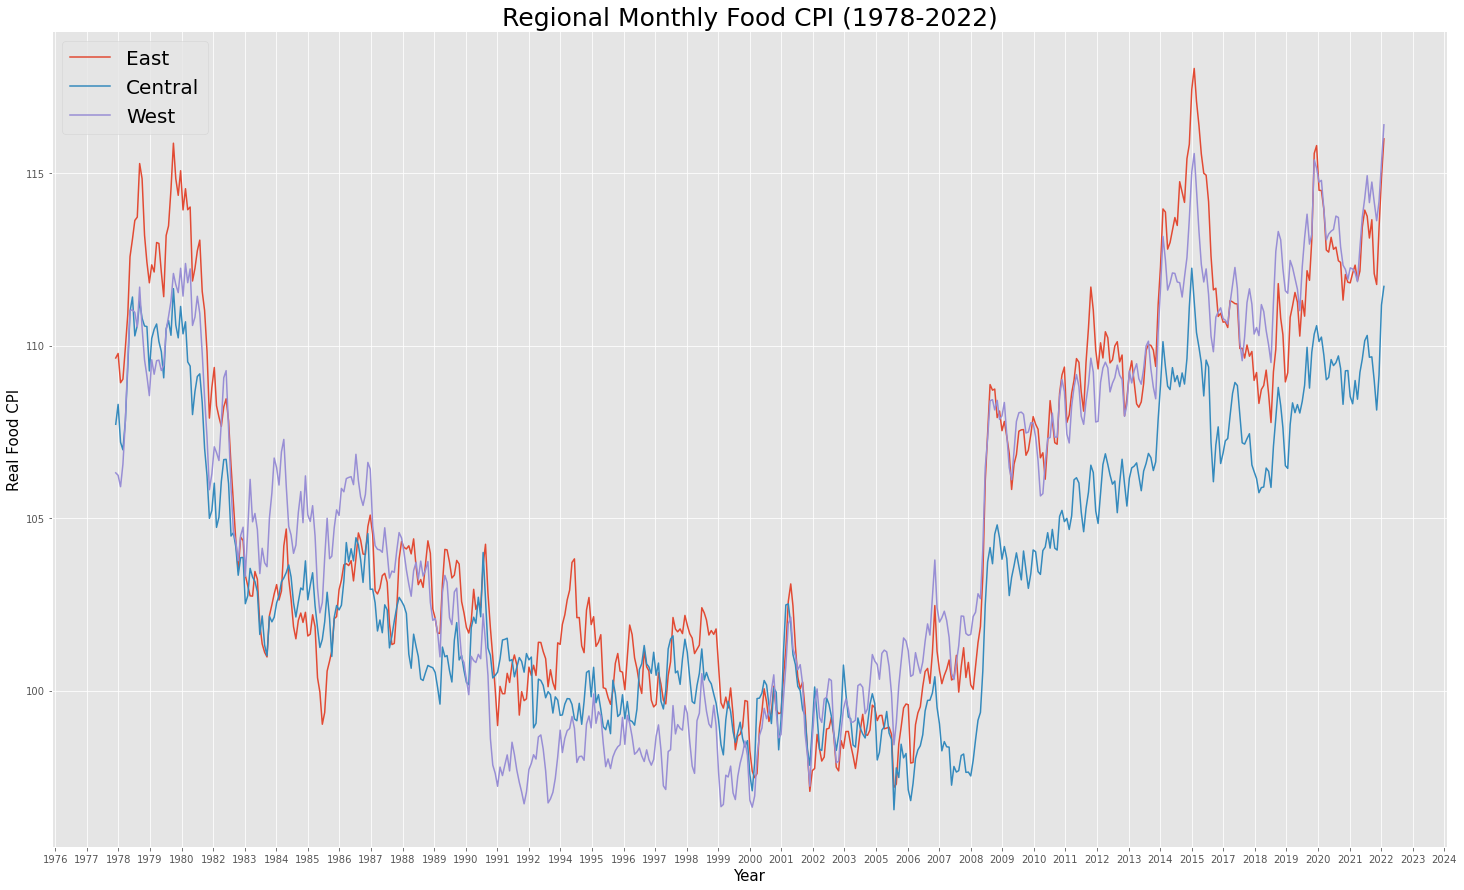

In [350]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize = (25, 15))

ax.xaxis.set_major_locator(plt.MaxNLocator(45))

plt.plot(dates, region_food["east"])
plt.plot(dates, region_food["west"])
plt.plot(dates, region_food["central"])

ax.set_title("Regional Monthly Food CPI (1978-2022)", size = 25)
ax.set_ylabel("Real Food CPI", fontsize=15, color="black")
ax.set_xlabel("Year", fontsize=15, color="black")
ax.legend(["East", "Central", "West"], prop={'size': 20})


### **Line Plot Interpretation**

- U-shape: real food prices start high, fall to their level of 100 in the base year of 2002, and then rise again

**Real Food_X CPI is a fraction:**

![](real_food_cpi.png)


- Variation in the plot could be due to changes in Food CPI or All-items CPI
- Cannot judge just from the plot

- Post-2002, Central values consistently 3-5 CPI lower than West and East
- West and East highly variable

**Shows the limits of data visualization** 

- Making out anything more specific than very broad trends from such a visualization is impossible. 

If we want to see more precisely how time trends work, if the regions' differences are statistically significant, whether it varies by food type, and what role exchange rates play (if any), we need a more formal model. 

So, next we will run our regression.

## Regression Model

We're going back to `all_food_cpi` for the regression.

As explanatory variables, I'll be using:

1. An intercept
2. Region dummy variable: `eastern` and `western` with `central` as the baseline
3. Product type dummy variables, with `Food` as the baseline
4. `EXCAUS`, the CAD/USD exchange rate

While prices rise overall with time (i.e. inflation), our outcome variable here is food CPI divided by overall CPI. There is no particular reason to think these are changing in any specific direction, so I'm not going to assume a time trend, which is why I don't use a variable for time elapsed.

### Regression Model Data Prep

In [315]:
# copying `all_food_cpi`
reg_1_df = all_food_cpi.copy()
# assigning intercept
reg_1_df["intercept"] = 1

# creating product dummies
reg_1_df["Meat"] = 0
reg_1_df["Dairy"] = 0
reg_1_df["Bakery"] = 0
reg_1_df["Veg"] = 0
# assigning 1 to proper dummy variables
reg_1_df.loc[reg_1_df['Products and product groups_x'] == 'Meat', 'Meat'] = 1
reg_1_df.loc[reg_1_df['Products and product groups_x'] == 'Dairy products and eggs', 'Dairy'] = 1
reg_1_df.loc[reg_1_df['Products and product groups_x'] == 'Bakery and cereal products (excluding baby food)', 'Bakery'] = 1
reg_1_df.loc[reg_1_df['Products and product groups_x'] == 'Vegetables and vegetable preparations', 'Veg'] = 1

# dropping unnecessary columns
reg_1_df.drop(["REF_DATE", "GEO", "VALUE", "Products and product groups_x", "central", "all_price_value"], axis=1, inplace=True)

reg_1_df

,eastern,western,EXCAUS,real_cpi,intercept,Meat,Dairy,Bakery,Veg
0,1,0,1.1664,114.248705,1,0,0,0,0
1,1,0,1.1664,127.720207,1,1,0,0,0
2,1,0,1.1664,111.658031,1,0,1,0,0
3,1,0,1.1664,98.186528,1,0,0,1,0
4,1,0,1.1664,107.253886,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
26445,0,1,1.3339,113.937754,1,0,0,0,0
26446,0,1,1.3339,129.499323,1,1,0,0,0
26447,0,1,1.3339,108.254398,1,0,1,0,0
26448,0,1,1.3339,113.734777,1,0,0,1,0


In [316]:
# taking dependent variable, and explanatory variables, apart
reg_1_outcome = reg_1_df["real_cpi"]
reg_1_exog = reg_1_df.drop("real_cpi", axis=1)

In [317]:
# running regression model 1

reg_1 = sm.OLS(reg_1_outcome, reg_1_exog)
reg_1_result = reg_1.fit(cov_type="HC3")
print(reg_1_result.summary())

                            OLS Regression Results                            
Dep. Variable:               real_cpi   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     344.1
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:59:58   Log-Likelihood:                -98129.
No. Observations:               26450   AIC:                         1.963e+05
Df Residuals:                   26442   BIC:                         1.963e+05
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eastern        0.2395      0.171      1.399      0.1

### Regression 1 Interpretation

#### Regions

We use `central` as a baseline. 

- `eastern` provinces have higher real food CPI, with a coefficient of 0.2395, but it's not statistically significant. 
- `western` provinces have on average lower real food CPI by -1.5154 points, and with a near-0 p-value, implying high statistical significance. 

The model finds smaller average differences once accounting for other variables than we noticed from 2002 onwards in our visualization above, just of general food prices.

### Product Types

Compared to "All Food"; 
- `Dairy` and `Bakery` products average higher real CPI at high statistical significance
- `Meat` and `Veg` products average lower real CPI, but only the latter is statistically significant

### Exchange Rate

- `EXCAUS` has a negative coefficient and is highly statistically significant

Recall that a higher `EXCAUS` implies a weaker Canadian dollar relative to the US. The negative coefficient suggests the weaker the dollar gets, the lower our food real CPI types go.

The nature of the Real Food CPI value might explain this. Food X's Real CPI is equal to Food X's CPI divided by All-Items CPI, then multiplied by 100. 

If we're more depenent on imports for general products than food, a weakening of the dollar means these prices in CAD are going to rise more than food prices, pushing up normal CPI by more than food CPI. Since increasing the denominator will lower overall Real Food CPI, this could explain the negative coeffient.  

In [318]:
print("Maximum, minimum, mean, std deviation of `EXCAUS`")
print("MAX: ", reg_1_exog["EXCAUS"].max())
print("MIN: ", reg_1_exog["EXCAUS"].min())
print("MEAN:", reg_1_exog["EXCAUS"].mean())
print("St. Dev:", reg_1_exog["EXCAUS"].std())

print("Maximum, minimum, mean of Real Food CPI Values")
print("MAX: ", reg_1_outcome.max())
print("MIN: ", reg_1_outcome.min())
print("MEAN:", reg_1_outcome.mean())
print("St. Dev:", reg_1_outcome.std())

Maximum, minimum, mean, std deviation of `EXCAUS`
MAX:  1.5997
MIN:  0.9553
MEAN: 1.2619385633270712
St. Dev: 0.14571217747861875
Maximum, minimum, mean of Real Food CPI Values
MAX:  181.5899581589958
MIN:  70.42410714285715
MEAN: 105.1934731081134
St. Dev: 10.289744536432528


### Exchange Rate Effect Size

Assessing the economic significance of the `EXCAUS` effect takes more work. 

- `EXCAUS` never goes below 0.95 or above 1.6. 
- An increase of `EXCAUS` by one standard deviation (0.146), multiplied by the effect size of -13.1177, suggests a fall of Real Food CPI by 2.01 points. 
- This is nearly 2% of the average Real Food CPI value (mean 105.19), but less than a fifth of its Standard Deviation (of 10.29).  

The magnitude of this effect depends on the level of Food Real CPI in the year it happens.  

- Even at the highest level of 181.60 it's still more than a 1% change, which will matter to households, and even more to producers. 
- Compare with the Bank of Canada's 2% inflation target

# Another Regression Version

While the above regression uses dummy variables for each product type and region, and `EXCAUS` as a separate variable, it doesn't separate out if `EXCAUS` might have an interaction with any of them. 

So, I'm going to run a regression with "interaction" variables added, by multiplying the exchange rate with each dummy variable. This allows each to have a different real food CPI effect from different levels of `EXCAUS`. 

In [ ]:
#reg_1_outcome = reg_1_df["real_cpi"]
#reg_1_exog = reg_1_df.drop("real_cpi", axis=1)

In [327]:
reg_2_df

,eastern,western,EXCAUS,real_cpi,intercept,Meat,Dairy,Bakery,Veg,ex_meat,ex_dairy,ex_bakery
0,1,0,1.1664,114.248705,1,0,0,0,0,0.0000,0.0000,0.0000
1,1,0,1.1664,127.720207,1,1,0,0,0,1.1664,1.1664,1.1664
2,1,0,1.1664,111.658031,1,0,1,0,0,0.0000,0.0000,0.0000
3,1,0,1.1664,98.186528,1,0,0,1,0,0.0000,0.0000,0.0000
4,1,0,1.1664,107.253886,1,0,0,0,1,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
26445,0,1,1.3339,113.937754,1,0,0,0,0,0.0000,0.0000,0.0000
26446,0,1,1.3339,129.499323,1,1,0,0,0,1.3339,1.3339,1.3339
26447,0,1,1.3339,108.254398,1,0,1,0,0,0.0000,0.0000,0.0000
26448,0,1,1.3339,113.734777,1,0,0,1,0,0.0000,0.0000,0.0000


In [356]:
reg_2_df = reg_1_df.copy()

reg_2_df["central"] = 0


#reg_2_df.loc[(reg_2_df["eastern"] == 0) AND (reg_2_df["western"] == 0), "central"] = 1

SyntaxError: invalid syntax (3229903104.py, line 4)

In [357]:
reg_2_df.loc[(reg_2_df["eastern"] == 0) & (reg_2_df["western"] == 0), "central"] = 1

In [371]:
reg_2_df = reg_1_df.copy()

reg_2_df["central"] = 0
reg_2_df.loc[(reg_2_df["eastern"] == 0) & (reg_2_df["western"] == 0), "central"] = 1

reg_2_df["all_food"] = 0
reg_2_df.loc[(reg_2_df["Meat"] == 0) & (reg_2_df["Dairy"] == 0) & (reg_2_df["Bakery"] == 0) & (reg_2_df["Veg"] == 0), "all_food"] = 1

reg_2_df["ex_meat"] = reg_2_df["Meat"]*reg_2_df["EXCAUS"]
reg_2_df["ex_dairy"] = reg_2_df["Dairy"]*reg_2_df["EXCAUS"]
reg_2_df["ex_bakery"] = reg_2_df["Bakery"]*reg_2_df["EXCAUS"]
reg_2_df["ex_veg"] = reg_2_df["Veg"]*reg_2_df["EXCAUS"]
reg_2_df["ex_all"] = reg_2_df["all_food"]*reg_2_df["EXCAUS"]


reg_2_df["ex_east"] = reg_2_df["eastern"]*reg_2_df["EXCAUS"]
reg_2_df["ex_west"] = reg_2_df["western"]*reg_2_df["EXCAUS"]
reg_2_df["ex_cent"] = reg_2_df["central"]*reg_2_df["EXCAUS"]

reg_2_df

,eastern,western,EXCAUS,real_cpi,intercept,Meat,Dairy,Bakery,Veg,central,all_food,ex_meat,ex_dairy,ex_bakery,ex_veg,ex_all,ex_east,ex_west,ex_cent
0,1,0,1.1664,114.248705,1,0,0,0,0,0,1,0.0000,0.0000,0.0000,0.0000,1.1664,1.1664,0.0000,0.0
1,1,0,1.1664,127.720207,1,1,0,0,0,0,0,1.1664,0.0000,0.0000,0.0000,0.0000,1.1664,0.0000,0.0
2,1,0,1.1664,111.658031,1,0,1,0,0,0,0,0.0000,1.1664,0.0000,0.0000,0.0000,1.1664,0.0000,0.0
3,1,0,1.1664,98.186528,1,0,0,1,0,0,0,0.0000,0.0000,1.1664,0.0000,0.0000,1.1664,0.0000,0.0
4,1,0,1.1664,107.253886,1,0,0,0,1,0,0,0.0000,0.0000,0.0000,1.1664,0.0000,1.1664,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,0,1,1.3339,113.937754,1,0,0,0,0,0,1,0.0000,0.0000,0.0000,0.0000,1.3339,0.0000,1.3339,0.0
26446,0,1,1.3339,129.499323,1,1,0,0,0,0,0,1.3339,0.0000,0.0000,0.0000,0.0000,0.0000,1.3339,0.0
26447,0,1,1.3339,108.254398,1,0,1,0,0,0,0,0.0000,1.3339,0.0000,0.0000,0.0000,0.0000,1.3339,0.0
26448,0,1,1.3339,113.734777,1,0,0,1,0,0,0,0.0000,0.0000,1.3339,0.0000,0.0000,0.0000,1.3339,0.0


In [372]:
reg_2_outcome = reg_2_df["real_cpi"]
reg_2_exog = reg_2_df.drop(["real_cpi", "central", "all_food"], axis=1)

In [374]:
# running regression model 1

reg_2 = sm.OLS(reg_2_outcome, reg_2_exog)
reg_2_result = reg_2.fit(cov_type="HC3")
print(reg_2_result.summary())

                            OLS Regression Results                            
Dep. Variable:               real_cpi   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     362.1
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:49:26   Log-Likelihood:                -97869.
No. Observations:               26450   AIC:                         1.958e+05
Df Residuals:                   26436   BIC:                         1.959e+05
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eastern        0.2159      1.186      0.182      0.8

c:\Users\jonah\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '


Our exchange rate/dummy variable interactions follow a similar pattern to the basic dummy variables. `Meat` and `eastern` are insignificant, both as dummy variables and when interacted with `EXCAUS` as `ex_meat` and `ex_east`. 

The otherwise extremely low p-values on most other variables suggests evidence for the exchange rate affecting their CPIs. 

- `ex_east`'s positive slope suggests a smaller effect of exchange rates on real food CPI in the east
- `ex_dairy` and `ex_bakery` have negative slopes, suggesting even larger price reductions from the Canadian dollar weakening
- `ex_veg` has a large positive slope, which mitigates over half of the basic `EXCAUS` effect on vegetable prices